<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/convnets/SqueezeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SqueezeNet

This network is known for providing AlexNet-Level accuracy at 50 times fewer parameters.
This small architecture offers three major advantages,
>  first, it requires less bandwidth
for exporting the model

>  then it requires less communication between server during
distributed training

>  more feasible to deploy on FPGAs.

Archiecture creates `Fire` module containing a squeeze convolution layer (which has only
1×1 filters), feeding into an expand layer that has a mix of 1×1 and 3×3 convolution filters.

To reduce the parameters the architecture follows design strategies

1. Using Conv1x1 over Conv3x3
2. Decreasing number of channels using Squeeze Layers
3. Downsample late in the network, such that convolution
layers have large activation maps.

1 and 2 helps in reducing the parameters, and 3 helps in higher classification accuracy
because of large activation maps.

Reference: https://github.com/Mayurji/Image-Classification-PyTorch/blob/main/SqueezeNet.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

Fire Module


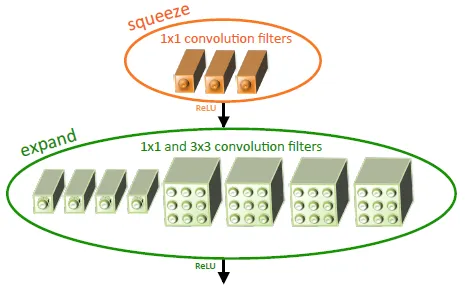

In [ ]:
from torchsummary import summary

In [ ]:
class Fire(nn.Module):
    def __init__(self,in_channel,squeeze_channel,expand_channel):
        super().__init__()

        #squeeze conv1x1
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channel,squeeze_channel,kernel_size = 1,stride = 1,bias = False),
            nn.BatchNorm2d(squeeze_channel),
            nn.ReLU(inplace = True)
        )
        #expand conv1x1
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channel,expand_channel,kernel_size = 1,stride = 1,bias = False),
                        nn.BatchNorm2d(expand_channel))
        #expand conv3x3
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channel,expand_channel,kernel_size = 3,stride = 1,padding = 1,bias = False),
            nn.BatchNorm2d(expand_channel)
        )

    def forward(self,x):
        squeeze_out = self.squeeze(x)
        expand_out_1x1 = self.expand1x1(squeeze_out)
        expand_out_3x3 = self.expand3x3(squeeze_out)
        out = torch.cat([expand_out_1x1,expand_out_3x3],1)
        out= F.relu(out)
        return out


In [ ]:
blk = Fire(96,16,64)
blk

Fire(
  (squeeze): Sequential(
    (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (expand1x1): Sequential(
    (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (expand3x3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:

summary(blk,(96,224,224))

out torch.Size([2, 128, 224, 224])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,536
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]           1,024
       BatchNorm2d-5         [-1, 64, 224, 224]             128
            Conv2d-6         [-1, 64, 224, 224]           9,216
       BatchNorm2d-7         [-1, 64, 224, 224]             128
Total params: 12,064
Trainable params: 12,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 18.38
Forward/backward pass size (MB): 116.38
Params size (MB): 0.05
Estimated Total Size (MB): 134.80
----------------------------------------------------------------


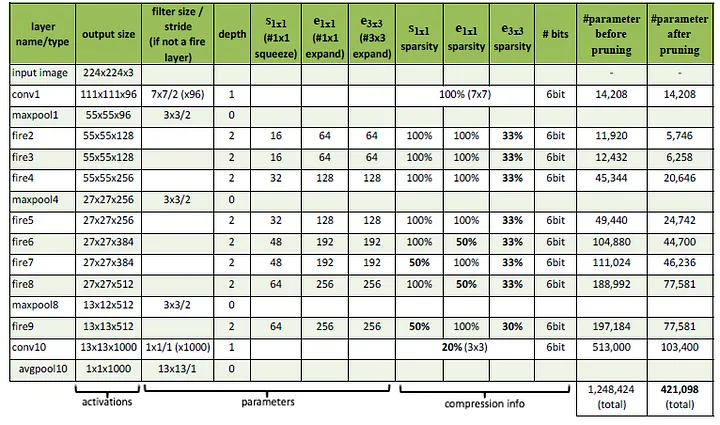

In [ ]:
class SqueezeNet(nn.Module):
    def __init__(self,in_channels,n_classes):
        super(SqueezeNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels,96,kernel_size = 7,stride = 2,padding = 3,bias = False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size= 3,stride = 2)
        )
        self.fire2 = Fire(96,16,64)
        self.fire3 = Fire(128,16,64)
        self.fire4 = Fire(128,32,128)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.fire5 = Fire(256,32,128)
        self.fire6 = Fire(256,48,192)
        self.fire7 = Fire(384,48,192)
        self.fire8 = Fire(384,64,256)
        self.maxpool8 = nn.MaxPool2d(kernel_size = 2,stride =2)
        self.fire9 = Fire(512,64,256)
        self.conv10 = nn.Conv2d(512,n_classes,kernel_size = 1,stride = 1)
        #self.avg_pool10 = nn.AvgPool2d(13)
        self.adaptive_avg_pool10 = nn.AdaptiveAvgPool2d(1)

        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0,math.sqrt(2/n))
            elif isinstance(m,nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def forward(self,x):
        out = self.conv1(x)
        out = self.fire2(out)
        out = self.fire3(out)
        out = self.fire4(out)
        out = self.maxpool4(out)
        out = self.fire5(out)
        out = self.fire6(out)
        out = self.fire7(out)
        out = self.fire8(out)
        out = self.maxpool8(out)
        out = self.fire9(out)
        out = self.conv10(out)
        #out = self.avg_pool10(out)
        out = self.adaptive_avg_pool10(out)
        out = out.view(out.size(0),-1)
        return out

In [ ]:
blk2 = SqueezeNet(3,10)
#summary(blk2,(3,224,224))

In [ ]:
blk2(torch.rand(2,3,224,224)).shape

torch.Size([2, 10])